In [1]:
from qick import *
import time, math
%pylab inline
soc = QickSoc("/home/xilinx/jupyter_notebooks/qick/firmware/top_216_bitstream/d_1.bit")
soccfg = soc
print(soccfg)
GEN_CH = 0
RO_CH = 0
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]
        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])
        sig_mode = "oneshot"
        if "mode" in cfg:
            sig_mode = (sig_mode, cfg["mode"])[cfg["mode"] == "periodic"]
        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)
        style=self.cfg["pulse_style"]
        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma*2, length=sigma*7)
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"], mode=sig_mode)
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", mode=sig_mode)
        self.synci(200)  # give processor some time to configure pulses
    def body(self):
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
class DoublePulseProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        gain = cfg["pulse_gain"]
        sig_mode = "oneshot"
        if "mode" in cfg:
            sig_mode = (sig_mode, cfg["mode"])[cfg["mode"] == "periodic"]

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.default_pulse_registers(ch=res_ch, style=style, freq=freq, gain=gain, 
                                         length=cfg["length"], mode=sig_mode)
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.default_pulse_registers(ch=res_ch, style=style, freq=freq, gain=gain, 
                                         waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.default_pulse_registers(ch=res_ch, style=style, freq=freq, gain=gain, 
                                         waveform="measure", mode=sig_mode)
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        phase1 = self.deg2reg(self.cfg["res_phase"], gen_ch=self.cfg["res_ch"])
        phase2 = self.deg2reg(self.cfg["res_phase"]+90, gen_ch=self.cfg["res_ch"])
        # fire a single trigger, but two pulses offset by 200 tProc clock ticks
        # with the first ADC trigger, pulse PMOD0_0 for a scope trigger
        # after the full sequence is set up, pause the tProc until readout is done
        # and increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.trigger(adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"])
        self.set_pulse_registers(ch=self.cfg["res_ch"], phase=phase1)
        self.pulse(ch=self.cfg["res_ch"], t=0)
        self.set_pulse_registers(ch=self.cfg["res_ch"], phase=phase2)
        self.pulse(ch=self.cfg["res_ch"], t=200)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: ZCU216

	Software version: 0.2.268
	Firmware timestamp: Tue Aug 20 16:47:20 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 32-bit DDS, range=6881.280 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope m

In [6]:
from pynq.lib.iic import AxiIIC
cur_addr=0x75
iic = AxiIIC(soc.ip_dict["axi_iic_0"])
iic.send(address=cur_addr, data=[0xde,0xad,0xbe,0xef], length=4, option=1)

4

In [18]:
from pynq.lib.iic import AxiIIC

iic = AxiIIC(soc.ip_dict["axi_iic_0"])
successful_address_send = []
for z in [0x40, 0x43, 0x44, 0x45, 0x4b, 0x4c, 0x75]: # multiple testing
    try:
        iic.send(address=z, data=[0xde,0xad,0xbe,0xef], length=4, option=1)
        iic.receive(address=z, data=[], length=4, option=0)
        time.sleep(0.2)
        successful_address_send.append(z)
    except Exception:
        pass
#iic.receive(address=0x75, data=[], length=4, option=0)
# https://www.adiuvoengineering.com/post/microzed-chronicles-pynq-and-axi-iic
print("0xDEADBEEF data is successfully written to " + str(len(successful_address_send)) + " addresses via I2C")
print("Successful write I2C address:\t" + ''.join(["0x" + hex(x)[2:].zfill(2) + ", " for x in successful_address_send])[:-2])

0xDEADBEEF data is successfully written to 7 addresses via I2C
Successful write I2C address:	0x40, 0x43, 0x44, 0x45, 0x4b, 0x4c, 0x75


  0%|          | 0/100 [00:00<?, ?it/s]

Attempting to read memory.
FIFO - phase reset	1 resets accumulator coherency		bool	0
FIFO - steady state	1 sets final value at 0, else last	bool	1
FIFO - repeat waveform	0 outputs # of pulses according to reps	bool	0
FIFO - output mode	0: prod, 1: DDS, 2:input, 3:zero	bool	0
FIFO - sample meas	# of repeated pulse output		int	100
FIFO - software gain	amplitude set from software		int	32767
FIFO - address		address set from software		int	0
FIFO - phase		phase offset from software		int	0
FIFO - frequency	frequency value set from software	int	137313525

Current 4 flags		(flag @ stop trigger, flag @ read)	bool[]	1010

0x01000102
0:	0xe0000
0:	0xf0000
0:	0xe0000	(recheck)
0:	0xf0000	(recheck)
1:	0xc0000
1:	0xd0000
1:	0xc0000	(recheck)
1:	0xd0000	(recheck)
2:	0xa0000
2:	0xb0000
2:	0xa0000	(recheck)
2:	0xb0000	(recheck)
0x02030405
3:	0xe3800
3:	0xf0000
3:	0xe3800	(recheck)
3:	0xf0000	(recheck)
4:	0xc0000
4:	0xd0039
4:	0xc0000	(recheck)
4:	0xd0039	(recheck)
5:	0xa0000
5:	0xb003a
5:	0xa0000	(reche

180:	0xe3900
180:	0xf0000
180:	0xe3900	(recheck)
180:	0xf0000	(recheck)
181:	0xc0000
181:	0xd003a
181:	0xc0000	(recheck)
181:	0xd003a	(recheck)
182:	0xa0000
182:	0xb003b
182:	0xa0000	(recheck)
182:	0xb003b	(recheck)
0x0eb7b8b9
183:	0xe3c00
183:	0xf0000
183:	0xe3c00	(recheck)
183:	0xf0000	(recheck)
184:	0xc0000
184:	0xd003d
184:	0xc0000	(recheck)
184:	0xd003d	(recheck)
185:	0xa0000
185:	0xb003e
185:	0xa0000	(recheck)
185:	0xb003e	(recheck)
0x0fbabbbc
186:	0xe3f00
186:	0xf0000
186:	0xe3f00	(recheck)
186:	0xf0000	(recheck)
187:	0xc0000
187:	0xd0040
187:	0xc0000	(recheck)
187:	0xd0040	(recheck)
188:	0xa0000
188:	0xb0041
188:	0xa0000	(recheck)
188:	0xb0041	(recheck)
0x00bdbebf
189:	0xe4200
189:	0xf0000
189:	0xe4200	(recheck)
189:	0xf0000	(recheck)
190:	0xc0000
190:	0xd0043
190:	0xc0000	(recheck)
190:	0xd0043	(recheck)
191:	0xa0000
191:	0xb0044
191:	0xa0000	(recheck)
191:	0xb0044	(recheck)
0x01c0c1c2
192:	0xe4500
192:	0xf0000
192:	0xe4500	(recheck)
192:	0xf0000	(recheck)
193:	0xc0000
193:	0x

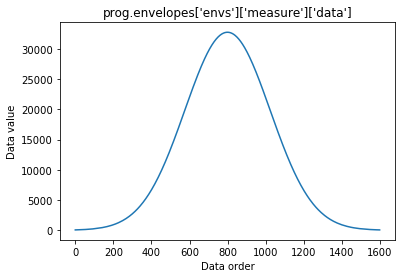

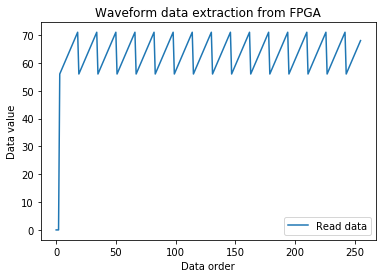

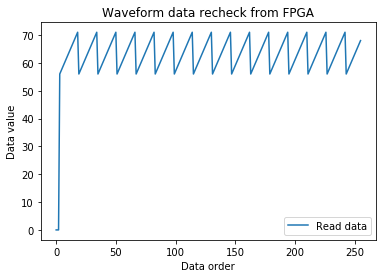

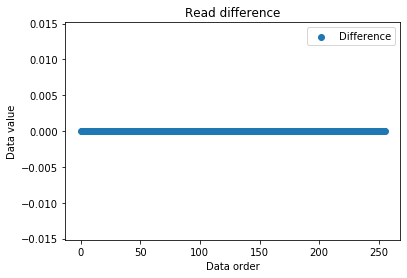

In [3]:
axi_read_address = 0xa0018000
axi_read_range = 0x1000
import pynq
mmio = pynq.MMIO(axi_read_address, axi_read_range)
mmio.write(8, 0x10000000)
mmio.write(8, 0x00000000)
config={"res_ch":GEN_CH, # --Fixed
        "ro_chs":[RO_CH], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "arb", # --Fixed
        #"mode": "periodic",
        "sigma": 20,
        "readout_length":300,
        "pulse_gain":32767,
        # DAC at 30000 corresponds to ~400 mV Vpp centered on 0 with input impedance 1M ohm, 1x probe, DC coupling
        "pulse_freq": 220, # [MHz]
        "adc_trig_offset": 100,
        "soft_avgs":100
       }

prog = DoublePulseProgram(soccfg, config)
iq_list = prog.acquire_decimated(soc)

time.sleep(1)

do_read = True
if "mode" in config:
    if config["mode"] == "periodic" and config["pulse_style"] != "flat_top":
        do_read = False
if do_read:
    print("Attempting to read memory.")
    mmio_result = ""
    mmio.write(0, 15 - 6)
    counter = 0
    while mmio_result != "1111":
        counter = (counter + 1) % 65536
        mmio.write(4, counter)
        mmio_result = bin(int(hex(mmio.read(0, 4))[-4:].zfill(4)[0], 16))[2:].zfill(4)
        if counter % 65536 == 0:
            print(mmio_result)
    read_output = []
    for axi_writ_offset in range(16):
        mmio.write(0, 15 - axi_writ_offset)
        read_output.append(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"))
    output_info = []
    # gauss_a = str(math.pow(int(read_output[0] + read_output[1], 16), 0.5))[:8] + " = " + str(int(read_output[0] + read_output[1], 16)) + " ^ 0.5"
    # output_info.append("Measured Gaussian a\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
    # gauss_b = str(int(read_output[2] + read_output[3], 16)) + " = " + hex(int(read_output[2] + read_output[3], 16))
    # output_info.append("Measured Gaussian b\ty = a * exp(-(x - b)^2 / (2c^2))\tint\t")
    # gauss_c = str(int(read_output[4] + read_output[5], 16) / (2 * math.pow(2 * math.log(2), 0.5)))[:8] + " = (2ln2)^(-0.5) * " + str(int(read_output[4] + read_output[5], 16))
    # output_info.append("Measured Gaussian c\ty = a * exp(-(x - b)^2 / (2c^2))\tfloat\t")
    # status_flag_past = bin(int(read_output[6][0], 16))[2:].zfill(4)
    # output_info.append("(Sanity) All 1s\t\tSanity check for legacy checkings\tbool[]\t")
    # status_flag_now_ = bin(int(read_output[6][1], 16))[2:].zfill(4)
    # output_info.append("Current 4 flags\t\t(flag @ stop trigger, flag @ read)\tbool[]\t")
    fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp = (lambda x: (x[3], x[4], x[5], int(x[6:8], 2), int(x[8:], 2)))(bin(int(read_output[6][2:] + read_output[7], 16))[2:].zfill(24))
    output_info.append("FIFO - phase reset\t1 resets accumulator coherency\t\tbool\t")
    output_info.append("FIFO - steady state\t1 sets final value at 0, else last\tbool\t")
    output_info.append("FIFO - repeat waveform\t0 outputs # of pulses according to reps\tbool\t")
    output_info.append("FIFO - output mode\t0: prod, 1: DDS, 2:input, 3:zero\tbool\t")
    output_info.append("FIFO - sample meas\t# of repeated pulse output\t\tint\t")
    fifo_gain = int(read_output[9], 16)
    output_info.append("FIFO - software gain\tamplitude set from software\t\tint\t")
    fifo_addr = int(read_output[11], 16)
    output_info.append("FIFO - address\t\taddress set from software\t\tint\t")
    fifo_phas = int(read_output[12] + read_output[13], 16)
    output_info.append("FIFO - phase\t\tphase offset from software\t\tint\t")
    fifo_freq = int(read_output[14] + read_output[15], 16)
    output_info.append("FIFO - frequency\tfrequency value set from software\tint\t")
    # refined_output = [gauss_a, gauss_b, gauss_c, status_flag_past, status_flag_now_, fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp, fifo_gain, fifo_addr, fifo_phas, fifo_freq]
    refined_output = [fifo_phrst, fifo_stdysel, fifo_mode, fifo_outsel, fifo_nsamp, fifo_gain, fifo_addr, fifo_phas, fifo_freq]
    for z, output_item in enumerate(refined_output):
        print(output_info[z] + str(output_item))
    print()
    status_flag_now_ = bin(int(read_output[6][1], 16))[2:].zfill(4)
    print("Current 4 flags\t\t(flag @ stop trigger, flag @ read)\tbool[]\t"+status_flag_now_)
    print()
    
waveform_read = []
waveform_ralt = []
if True:
    command_send_base = 0x01000000
    command_send = command_send_base
    value = 0
    for memory_pos in range(256):
        command_send = command_send + int(pow(256, 2 - memory_pos % 3)) * memory_pos
        if memory_pos % 3 == 2 or memory_pos == 255:
            counter = (counter + 1) % 65536
            sent_command = hex(command_send)
            mmio.write(4, counter)
            mmio.write(8, command_send)
            #mmio.write(0, 9)
            #mmio_result = bin(int(hex(mmio.read(0, 4))[-4:].zfill(4)[1], 16))[2:].zfill(4)
            #print("Flag status - " + mmio_result)
            print("0x" + sent_command[2:].zfill(8))
            mmio.write(0, 14)
            value = (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(4, 4)))
            print(str(memory_pos - (2, 0)[memory_pos == 255])+":\t"+hex(mmio.read(0, 4)))
            #value = complex(imag=int(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"), 16))
            mmio.write(0, 15)
            value = value + (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(0, 4)))
            print(str(memory_pos - (2, 0)[memory_pos == 255])+":\t"+hex(mmio.read(0, 4)))
            #value = value + complex(real=int(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"), 16))
            waveform_read.append(value)
            mmio.write(0, 14)
            print(str(memory_pos - (2, 0)[memory_pos == 255])+":\t"+hex(mmio.read(0, 4))+"\t(recheck)")
            value = (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(4, 4)))
            mmio.write(0, 15)
            print(str(memory_pos - (2, 0)[memory_pos == 255])+":\t"+hex(mmio.read(0, 4))+"\t(recheck)")
            value = value + (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(0, 4)))
            waveform_ralt.append(value)
            #print(sent_command + " - " + str(value))
            command_send = command_send_base * (counter % 16)
            if memory_pos % 3 == 2:
                mmio.write(0, 12)
                value = (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(0, 4)))
                print(str(memory_pos - 1)+":\t"+hex(mmio.read(0, 4)))
                #value = complex(imag=int(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"), 16))
                mmio.write(0, 13)
                value = value + (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(0, 4)))
                print(str(memory_pos - 1)+":\t"+hex(mmio.read(0, 4)))
                #value = value + int(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"), 16)
                waveform_read.append(value)
                mmio.write(0, 12)
                print(str(memory_pos - 1)+":\t"+hex(mmio.read(0, 4))+"\t(recheck)")
                value = (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(0, 4)))
                mmio.write(0, 13)
                print(str(memory_pos - 1)+":\t"+hex(mmio.read(0, 4))+"\t(recheck)")
                value = value + (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(0, 4)))
                waveform_ralt.append(value)
                mmio.write(0, 10)
                value = (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(0, 4)))
                print(str(memory_pos)+":\t"+hex(mmio.read(0, 4)))
                #value = complex(imag=int(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"), 16))
                mmio.write(0, 11)
                value = value + (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(0, 4)))
                print(str(memory_pos)+":\t"+hex(mmio.read(0, 4)))
                #value = value + int(hex(mmio.read(0, 4))[-4:].zfill(4).replace("x","0"), 16)
                waveform_read.append(value)
                mmio.write(0, 10)
                print(str(memory_pos)+":\t"+hex(mmio.read(0, 4))+"\t(recheck)")
                value = (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(0, 4)))
                mmio.write(0, 11)
                print(str(memory_pos)+":\t"+hex(mmio.read(0, 4))+"\t(recheck)")
                value = value + (lambda x: int(x[-4:-2], 16) + int(x[-2:], 16))(hex(mmio.read(0, 4)))
                waveform_ralt.append(value)
graph_made = False
#print(prog.envelopes)
for env_entity in prog.envelopes:
    if "measure" in env_entity["envs"]:
        plt.figure(1)
        plt.plot(*zip(*enumerate([x[0] for x in env_entity["envs"]["measure"]["data"]])))
        plt.xlabel("Data order")
        plt.ylabel("Data value")
        plt.title("prog.envelopes[\'envs\'][\'measure\'][\'data\']")
        graph_made = True
if not graph_made:
    print("\nFound nothing on prog.envelopes list")
waveform_read_len = len(waveform_read)
if waveform_read_len > 0:
    plt.figure(2)
    plt.plot(range(waveform_read_len), waveform_read, label="Read data")
    #plt.plot(range(waveform_read_len), [point.imag for point in waveform_read], label="Imag")
    #plt.plot(range(waveform_read_len), [abs(point) for point in waveform_read], label="Abso")
    plt.xlabel("Data order")
    plt.ylabel("Data value")
    plt.title("Waveform data extraction from FPGA")
    plt.legend()
else:
    print("\nFound nothing on waveform_read data")
waveform_read_len = len(waveform_ralt)
if waveform_read_len > 0:
    plt.figure(3)
    plt.plot(range(waveform_read_len), waveform_ralt, label="Read data")
    #plt.plot(range(waveform_read_len), [point.imag for point in waveform_read], label="Imag")
    #plt.plot(range(waveform_read_len), [abs(point) for point in waveform_read], label="Abso")
    plt.xlabel("Data order")
    plt.ylabel("Data value")
    plt.title("Waveform data recheck from FPGA")
    plt.legend()
else:
    print("\nFound nothing on waveform_ralt data")
read_diff = list(map(lambda x,y: abs(x - y), waveform_read, waveform_ralt))
waveform_read_len = len(read_diff)
if waveform_read_len > 0:
    plt.figure(4)
    plt.scatter(range(waveform_read_len), read_diff, label="Difference")
    #plt.plot(range(waveform_read_len), [point.imag for point in waveform_read], label="Imag")
    #plt.plot(range(waveform_read_len), [abs(point) for point in waveform_read], label="Abso")
    plt.xlabel("Data order")
    plt.ylabel("Data value")
    plt.title("Read difference")
    plt.legend()
else:
    print("\nFound nothing on diff data")